In [18]:
import openai
import os
import json

from dotenv import find_dotenv, load_dotenv 
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages


_ = load_dotenv(find_dotenv())
openai.api_key = os.environ['OPENAI_API_KEY']

In [19]:
class AgentState(TypedDict):
    """The state of the agent.
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [20]:
model = ChatOpenAI(model="gpt-4o-mini")

@tool
def get_weather(location: str):
    """Call to get the weather from a specific location.
    """
    if any([city in location.lower() for city in ["sf", "san francisco"]]):
        return "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    else:
        return f"I am not sure what the weather is in {location}"

tools = [get_weather]

model = model.bind_tools(tools)

In [21]:
tools_by_name = {tool.name: tool for tool in tools}

# define our tool node
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


# define the node that calls the model
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with 'prompt' parameter, but is more flexible
    system_prompt = SystemMessage(
        "You are a helpful AI assistant, please respond to the users query to the best of your ability!"
    )
    response = model.invoke([system_prompt] + state["messages"], config)
    return {"messages": [response]}


# define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

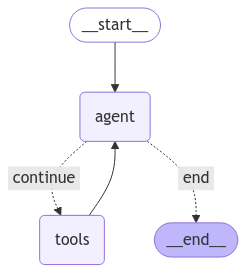

In [23]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)

workflow.add_edge("tools", "agent")

graph = workflow.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
inputs = {"messages": [("user", "what is the weather in sf")]}
graph.invoke(inputs)

{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='5eae3168-c639-4991-9be9-311049fc4654'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ReFbheGLFkCO5xcKwZEJ0SPK', 'function': {'arguments': '{"location":"San Francisco"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 73, 'total_tokens': 89, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-df0c0215-dc57-4751-a95d-7078eaf7a075-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'San Francisco'}, 'id': 'call_ReFbheGLFkCO5xcKwZEJ0SPK', 'type': 'tool_call'}], usage_